## Intention
In this Notebook, we describe how to get, analyze, and visualize level data from Lake Constance (Bodensee).
Creation Date 2022-08.

## Setup
We analyze the data in Python, whereby the data is stored and processed in AWS (S3 and SageMaker).

## Data

#### Download the data

We process public data taken from Hochwasservorhersagezentrale Baden-Württemberg (HVZ BaWü).
Go to
https://udo.lubw.baden-wuerttemberg.de/public/pages/home/welcome.xhtml
(Sorry, this is all in German.)

Go to
Select Wasser -> Oberflächengewässer -> Hydrologische Landespegel -> Hydrologische Landespegel (2x)

On the next page, select
* Gewässer = Bodensee
* Station = Konstanz Bodensee
* Komponente = Wasserstand, W-Stand, cm
* Produkt = Tagesmaximalwerte
* Zeitraum = 01.01.1850 - 31.12.2022

Export the data as *.csv (roughly 6 MB).

#### Adjust the file
* rows 1 - 6 contain the metadata - I removed this
* rows 7 - 8 are empty - deleted as well
* row 9 contains the column headers - I replaced the word “Gewässer” with “Gewasser”, just to get rid of the special character

#### Store in AWS
We store the file in S3.
* bucket ='s3davibec/Bodensee'
* data_key = 'Max_KN_1850-bis-heute_clean.csv'

## Data Processing
We use AWS service SageMaker Studio for the processing of the data based on the Jupyter Notebook given below.

#### 1/ Import Libraries

In [4]:
#import pandas
import pandas as pd

#### 2/ Read CSV file

In [5]:
# read csv file from S3 bucket
bucket ='s3davibec/Bodensee'
data_key = 'Max_KN_1850-bis-heute_clean.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location)

# print
print(df.head())

   Messstellennummer       Stationsname  Gewasser Parameter   Datum / Uhrzeit  \
0                906  Konstanz Bodensee  Bodensee   W-Stand  1850-01-01 00:00   
1                906  Konstanz Bodensee  Bodensee   W-Stand  1850-01-02 00:00   
2                906  Konstanz Bodensee  Bodensee   W-Stand  1850-01-03 00:00   
3                906  Konstanz Bodensee  Bodensee   W-Stand  1850-01-04 00:00   
4                906  Konstanz Bodensee  Bodensee   W-Stand  1850-01-05 00:00   

  Zeitbezug  Wert Einheit           Produkt  
0       MEZ   306      cm  Tagesmaximalwert  
1       MEZ   303      cm  Tagesmaximalwert  
2       MEZ   303      cm  Tagesmaximalwert  
3       MEZ   300      cm  Tagesmaximalwert  
4       MEZ   300      cm  Tagesmaximalwert  


#### Rename all columns to English
As mentioned before, the data is in German. Column names are translated to English in this step.

In [6]:
#Rename all columns to English

df = df.rename(columns={
    'Messstellennummer': 'measuring_point_number',
    'Stationsname': 'station_name',
    'Gewasser': 'waters',
    'Parameter': 'parameter',
    'Datum / Uhrzeit': 'date_time',
    'Zeitbezug': 'time_zone',
    'Wert': 'value',
    'Einheit': 'unit',
    'Produkt': 'value_type'
    })

# print
print(df.head())

   measuring_point_number       station_name    waters parameter  \
0                     906  Konstanz Bodensee  Bodensee   W-Stand   
1                     906  Konstanz Bodensee  Bodensee   W-Stand   
2                     906  Konstanz Bodensee  Bodensee   W-Stand   
3                     906  Konstanz Bodensee  Bodensee   W-Stand   
4                     906  Konstanz Bodensee  Bodensee   W-Stand   

          date_time time_zone  value unit        value_type  
0  1850-01-01 00:00       MEZ    306   cm  Tagesmaximalwert  
1  1850-01-02 00:00       MEZ    303   cm  Tagesmaximalwert  
2  1850-01-03 00:00       MEZ    303   cm  Tagesmaximalwert  
3  1850-01-04 00:00       MEZ    300   cm  Tagesmaximalwert  
4  1850-01-05 00:00       MEZ    300   cm  Tagesmaximalwert  


#### 4/ Add Data Conversions
We need new different data points, like the month-day combination [“mm_dd”].

In [7]:
#add all date conversions
df['date'] = pd.to_datetime(df['date_time']).dt.date
df['year'] = pd.to_datetime(df['date_time']).dt.year
df['month'] = pd.to_datetime(df['date_time']).dt.month
df['day'] = pd.to_datetime(df['date_time']).dt.day

#convert Month and Day to two digit format
import io

df["month"] = df.month.map("{:02}".format)
df["day"] = df.day.map("{:02}".format)

#new column
df["mm_dd"] = df["month"].astype(str) + "_" + df["day"].astype(str)


# print
print(df.head())

   measuring_point_number       station_name    waters parameter  \
0                     906  Konstanz Bodensee  Bodensee   W-Stand   
1                     906  Konstanz Bodensee  Bodensee   W-Stand   
2                     906  Konstanz Bodensee  Bodensee   W-Stand   
3                     906  Konstanz Bodensee  Bodensee   W-Stand   
4                     906  Konstanz Bodensee  Bodensee   W-Stand   

          date_time time_zone  value unit        value_type        date  year  \
0  1850-01-01 00:00       MEZ    306   cm  Tagesmaximalwert  1850-01-01  1850   
1  1850-01-02 00:00       MEZ    303   cm  Tagesmaximalwert  1850-01-02  1850   
2  1850-01-03 00:00       MEZ    303   cm  Tagesmaximalwert  1850-01-03  1850   
3  1850-01-04 00:00       MEZ    300   cm  Tagesmaximalwert  1850-01-04  1850   
4  1850-01-05 00:00       MEZ    300   cm  Tagesmaximalwert  1850-01-05  1850   

  month day  mm_dd  
0    01  01  01_01  
1    01  02  01_02  
2    01  03  01_03  
3    01  04  01_04  

#### 5/ Reduce Data to Minimum
Create a new dataset with a minimum of data to make things easier in the next couple of steps.

In [8]:
# creating a new dataset dfs with the minimum data I will need in the next couple of steps
dfs = df[['value','date','year','mm_dd']]

# print
dfs.head()

,value,date,year,mm_dd
0,306,1850-01-01,1850,01_01
1,303,1850-01-02,1850,01_02
2,303,1850-01-03,1850,01_03
3,300,1850-01-04,1850,01_04
4,300,1850-01-05,1850,01_05


#### 6/ Check Data Types
This might be a good time to check data types.

In [376]:
# check the data types of the various fields
# apply the dtype attribute
result = dfs.dtypes

print("Output:")
print(result)

Output:
value     int64
date     object
year      int64
mm_dd    object
dtype: object


#### 7/ Get Min, Max, Mean
Now I am creating a new data set with the three long-term values. For every day of the year, we calculate the Max, the Min, and the Mean.

In [236]:
# create new dataframe with min max mean values for each month date combination
df_mmm = dfs.groupby('mm_dd').agg(value_min=('value', 'min'), 
                             value_mean=('value', 'mean'), 
                             value_max=('value', 'max')).reset_index()

# print
df_mmm.head()

,mm_dd,value_min,value_mean,value_max
0,01_01,242,294.433526,390
1,01_02,242,293.976879,388
2,01_03,242,293.433526,391
3,01_04,241,293.271676,392
4,01_05,241,292.976879,391


#### 8/ Missed the month info on my way, so I need to bring this back in
I reduced the data in step 5/. But I missed to keep to month info in. For the data visualization, this info is handy. Therefore I re-create a month column.

In [237]:
# extract the first to characters from field mm_dd in order to get the month information back
df_mmm['month'] = df_mmm['mm_dd'].str[:2]

# print
df_mmm.head()

,mm_dd,value_min,value_mean,value_max,month
0,01_01,242,294.433526,390,01
1,01_02,242,293.976879,388,01
2,01_03,242,293.433526,391,01
3,01_04,241,293.271676,392,01
4,01_05,241,292.976879,391,01


#### 9/ Visualize: Max, Min, Avg
As a first visualization, I am simply setting up the Max, Min, and Mean value. Comparing this to the original graph from the data source, I can check whether my processing is okay. I use matplotlib for this purpose.

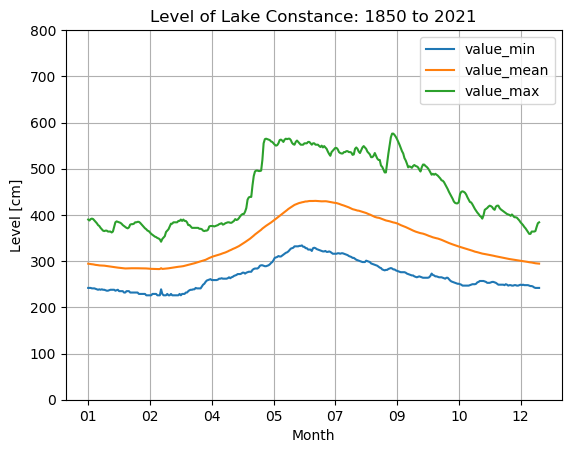

In [379]:
# print min, max, and mean for long-term data
# ---

# import matplotlib
import matplotlib.pyplot as plt

# plot
df_mmm.plot(x='month', kind='line')

plt.ylim(bottom=0, top=800)

# description
plt.title("Level of Lake Constance: 1850 to 2021")
plt.xlabel("Month")
plt.ylabel("Level [cm]")


# add grid
plt.grid()

plt.show()

#### 10/ Add 2022 data
The intention in this step is to create a data frame with Max, Min, Mean, and 2022 data.

In [325]:
# create dataframe with 2022 data based on dfs
dfs2022 = dfs.loc[dfs['year']==2022]

In [326]:
# drop not needed columns
dfs2022 = dfs2022.drop(columns=['date','year'], axis=1)

In [380]:
#rename value column
dfs2022 = dfs2022.rename(columns={'value': 'value_2022'})

# print
dfs2022.head()

,value_2022,mm_dd
62822,325,01_01
62823,326,01_02
62824,325,01_03
62825,325,01_04
62826,327,01_05


In [244]:
df_mmm_2022 = pd.merge(df_mmm, dfs2022, how="left", on="mm_dd")

# print
df_mmm_2022.head()

,mm_dd,value_min,value_mean,value_max,month,value_2022
0,01_01,242,294.433526,390,01,325.0
1,01_02,242,293.976879,388,01,326.0
2,01_03,242,293.433526,391,01,325.0
3,01_04,241,293.271676,392,01,325.0
4,01_05,241,292.976879,391,01,327.0


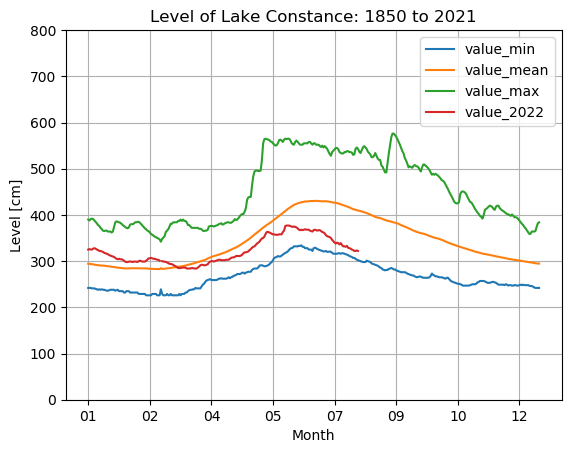

In [381]:
# visualize
# print min, max, and mean for long-term data
# ---

# import matplotlib
import matplotlib.pyplot as plt

# plot
df_mmm_2022.plot(x='month', kind='line')

plt.ylim(bottom=0, top=800)

# description
plt.title("Level of Lake Constance: 1850 to 2021")
plt.xlabel("Month")
plt.ylabel("Level [cm]")


# add grid
plt.grid()

plt.show()

#### 11/ Check for years with low levels at that time of the year
In August, people thought that Lake Constance might see a record low for this time of the year. All Germany saw a record droud. With that, I wanted to understand which years saw lower sea levels.

Get lowest value for the fifth of August:

In [403]:
# get the lowest values on a certain day of the year
# ---

# filter data frame by value
filter_value = {'08_05'}
dfs_min = dfs.loc[dfs['mm_dd'].isin(filter_value)]

# print
dfs_min.head()

,value,date,year,mm_dd
216,438,1850-08-05,1850,08_05
581,546,1851-08-05,1851,08_05
947,411,1852-08-05,1852,08_05
1312,476,1853-08-05,1853,08_05
1677,425,1854-08-05,1854,08_05


In [404]:
# sort the data
dfs_min = dfs_min.sort_values(by='value', ascending=True)

# print
dfs_min.head(10)

,value,date,year,mm_dd
36375,303,1949-08-05,1949,08_05
56098,312,2003-08-05,2003,08_05
57194,315,2006-08-05,2006,08_05
41854,317,1964-08-05,1964,08_05
63039,323,2022-08-05,2022,08_05
61577,330,2018-08-05,2018,08_05
56829,330,2005-08-05,2005,08_05
26148,330,1921-08-05,1921,08_05
7521,333,1870-08-05,1870,08_05
37471,337,1952-08-05,1952,08_05


now we know that the water level was lower than in 2022 in four occasions before: 
* 1949
* 2003
* 2006
* 1964
This is in ascending order. 1949 saw the lowest value ever recorded on 08/05.

It is important to note that there are five years after 2000 in this (negative) Top10 list.

#### 12a/ Dive deeper

Let us have a closer look at the 1949 data.

In [407]:
# let us look at 1949 vs 2022 vs min, max, mean
# ---

# create dataframe with 1949 data based on dfs
dfs1949 = dfs.loc[df['year'] == 1949]

In [408]:
# drop not needed columns
dfs1949 = dfs1949.drop(columns=['date','year'], axis=1)

In [409]:
#rename value column
dfs1949 = dfs1949.rename(columns={'value': 'value_1949'})

# print
dfs1949.head()

,value_1949,mm_dd
36159,242,01_01
36160,242,01_02
36161,242,01_03
36162,242,01_04
36163,242,01_05


In [410]:
# merge the 1949 data to the dataframe created for 2022
df_mmm_1949 = pd.merge(df_mmm_2022, dfs1949, how="left", on="mm_dd")

# print
df_mmm_1949.head()

,mm_dd,value_min,value_mean,value_max,month,value_2022,value_1949
0,01_01,242,294.433526,390,01,325.0,242.0
1,01_02,242,293.976879,388,01,326.0,242.0
2,01_03,242,293.433526,391,01,325.0,242.0
3,01_04,241,293.271676,392,01,325.0,242.0
4,01_05,241,292.976879,391,01,327.0,242.0


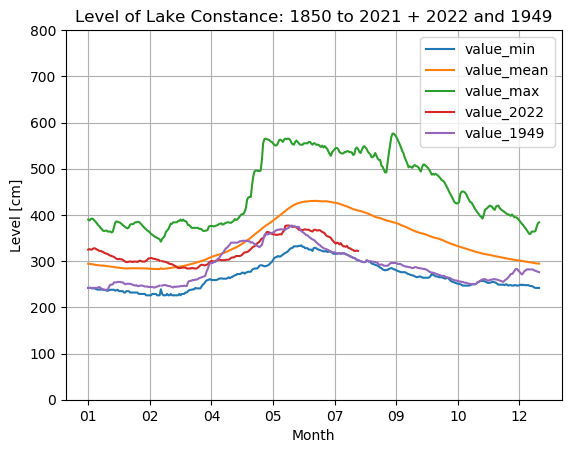

In [413]:
# visualize
# print min, max, and mean for long-term data
# ---

# import matplotlib
import matplotlib.pyplot as plt

# plot
df_mmm_1949.plot(x='month', kind='line')

plt.ylim(bottom=0, top=800)

# description
plt.title("Level of Lake Constance: 1850 to 2021 + 2022 and 1949")
plt.xlabel("Month")
plt.ylabel("Level [cm]")

# add grid
plt.grid()

plt.show()

#### 12b/ Zoom in summer 1949
We need to have a closer look here.

In [311]:
# let us zoom in a little bit
# ---

# filter data frame by value
filter_value = {'05','06','07','08'}
df_mmm_1949_zoom = df_mmm_1949.loc[df_mmm_1949['month'].isin(filter_value)]

# drop not needed columns
df_mmm_1949_zoom = df_mmm_1949_zoom.drop(columns=['value_max'], axis=1)

# print
df_mmm_1949_zoom.head()

,mm_dd,value_min,value_mean,month,value_2022,value_1949
121,05_01,272,331.023121,05,311.0,340.0
122,05_02,272,332.508671,05,311.0,341.0
123,05_03,272,334.196532,05,311.0,343.0
124,05_04,273,335.826590,05,312.0,343.0
125,05_05,275,337.780347,05,314.0,344.0


In [315]:
# check number of rows in df
len(df_mmm_1949_zoom)

124

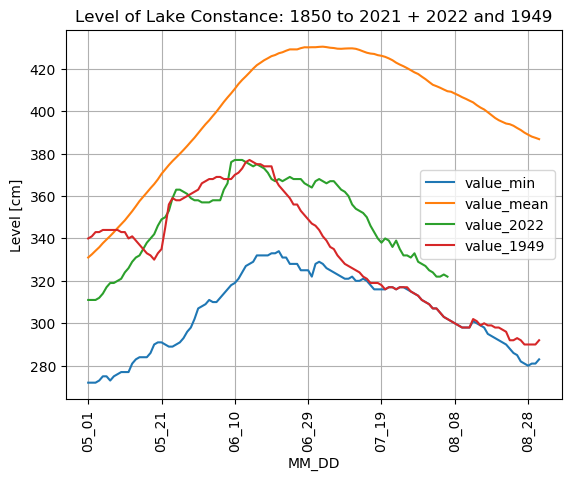

In [414]:
# visualize
# print zoom
# ---

# import matplotlib
import matplotlib.pyplot as plt

# plot
df_mmm_1949_zoom.plot(x='mm_dd', kind='line', rot=90)

# plt.ylim(bottom=0, top=800)

# description
plt.title("Level of Lake Constance: 1850 to 2021 + 2022 and 1949")
plt.xlabel("MM_DD")
plt.ylabel("Level [cm]")

# add grid
plt.grid()

plt.show()

#### 13/ All time Max
Next, we have a look into the all-time max value.

In [318]:
# now let us check out the max value
# ---

# get the max values for all columns
print(dfs.max())

value           576
date     2022-08-06
year           2022
mm_dd         12_31
dtype: object


In [331]:
# now we know that the highest value is 576, but in which year did that occur?

dfs_max = dfs.loc[df['value']==576]

# print
dfs_max

,value,date,year,mm_dd
14855,576,1890-09-03,1890,09_03
14856,576,1890-09-04,1890,09_04


The answer is 1890
What did this year look like?

In [332]:
# create dataframe with 1890 data based on dfs
dfs1890 = dfs.loc[df['year'] == 1890]

In [334]:
# drop not needed columns
dfs1890 = dfs1890.drop(columns=['date','year'], axis=1)

In [335]:
#rename value column
dfs1890 = dfs1890.rename(columns={'value': 'value_1890'})

# print
dfs1890.head()

,value_1890,mm_dd
14610,289,01_01
14611,288,01_02
14612,287,01_03
14613,285,01_04
14614,284,01_05


In [340]:
# merge the data
dfs_mmm_1890 = pd.merge(dfs1890, df_mmm, how="left", on="mm_dd")

# print
dfs_mmm_1890.head()

,value_1890,mm_dd,value_min,value_mean,value_max,month
0,289,01_01,242,294.433526,390,01
1,288,01_02,242,293.976879,388,01
2,287,01_03,242,293.433526,391,01
3,285,01_04,241,293.271676,392,01
4,284,01_05,241,292.976879,391,01


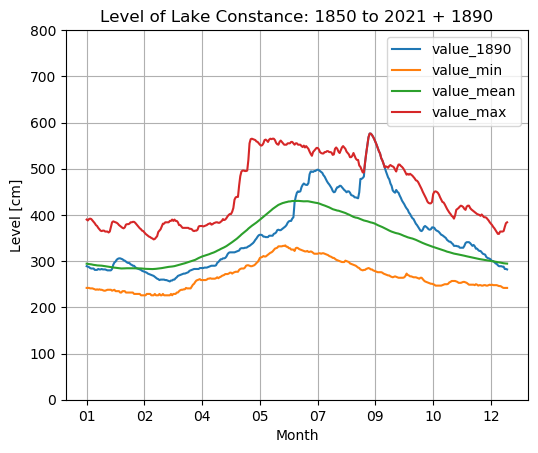

In [415]:
# visualize
# print min, max, and mean for long-term data
# ---

# import matplotlib
import matplotlib.pyplot as plt

# plot
dfs_mmm_1890.plot(x='month', kind='line')

plt.ylim(bottom=0, top=800)

# description
plt.title("Level of Lake Constance: 1850 to 2021 + 1890")
plt.xlabel("Month")
plt.ylabel("Level [cm]")

# add grid
plt.grid()

plt.show()

#### 14/ Check year 1999
I still remember the flood from summer 1999. At that time, the military took us to school. Let us have a look at this year.

In [416]:
# and what was 1999
# ---

# create dataframe with 1999 data based on dfs
dfs1999 = dfs.loc[df['year'] == 1999]

In [345]:
# drop not needed columns
dfs1999 = dfs1999.drop(columns=['date','year'], axis=1)

In [346]:
#rename value column
dfs1999 = dfs1999.rename(columns={'value': 'value_1999'})

# print
dfs1999.head()

,value_1999,mm_dd
54421,302,01_01
54422,300,01_02
54423,297,01_03
54424,296,01_04
54425,294,01_05


In [350]:
dfs_1890_1999 = pd.merge(dfs1890, dfs1999, how="left", on="mm_dd")

# print

dfs_1890_1999.head()

,value_1890,mm_dd,value_1999
0,289,01_01,302
1,288,01_02,300
2,287,01_03,297
3,285,01_04,296
4,284,01_05,294


In [351]:
dfs_mmm_1890_1999 = pd.merge(dfs_1890_1999, df_mmm, how="left", on="mm_dd")

# print
dfs_mmm_1890_1999.head()

,value_1890,mm_dd,value_1999,value_min,value_mean,value_max,month
0,289,01_01,302,242,294.433526,390,01
1,288,01_02,300,242,293.976879,388,01
2,287,01_03,297,242,293.433526,391,01
3,285,01_04,296,241,293.271676,392,01
4,284,01_05,294,241,292.976879,391,01


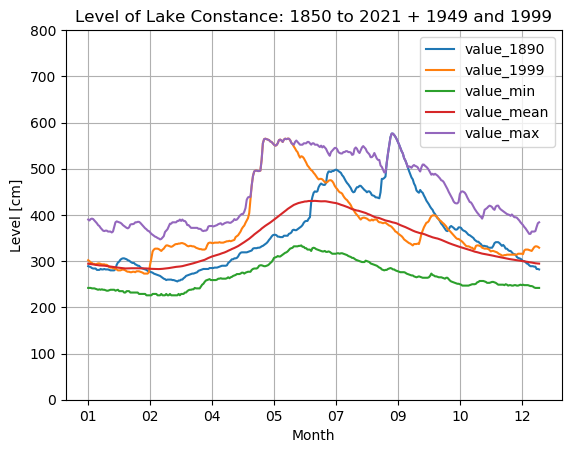

In [419]:
# visualize
# print min, max, and mean for long-term data
# ---

# import matplotlib
import matplotlib.pyplot as plt

# plot
dfs_mmm_1890_1999.plot(x='month', kind='line')

plt.ylim(bottom=0, top=800)

# description
plt.title("Level of Lake Constance: 1850 to 2021 + 1949 and 1999")
plt.xlabel("Month")
plt.ylabel("Level [cm]")

# add grid
plt.grid()

plt.show()